In [7]:
import json
import pandas as pd
import random
from music21 import converter, note, chord, stream
from fractions import Fraction

def load_json_data(file_path):
    """Loads the JSON data from a file."""
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        exit()
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file '{file_path}'.")
        exit()

def extract_abc_notations(data):
    """Extracts ABC notation from a list of dictionaries."""
    return [item.get('abc notation') for item in data if 'abc notation' in item]

def select_random_abc(abc_notations):
    """Randomly selects an ABC notation from the list."""
    if not abc_notations:
        print("No ABC notations found in the JSON data.")
        exit()
    return random.choice(abc_notations)

def prepare_abc_notation(selected_abc):
    """Prepares the ABC notation by adding headers if missing."""
    abc_header = ''
    if not selected_abc.startswith('X:'):
        abc_header += 'X:1\n'
    if 'K:' not in selected_abc:
        abc_header += 'K:C\n'
    return abc_header + selected_abc

def parse_abc_to_score(abc_notation):
    """Parses ABC notation to a music21 score object."""
    try:
        return converter.parse(abc_notation, format='abc')
    except Exception as e:
        print(f"Error parsing ABC notation with music21: {e}")
        exit()

def extract_musical_info(score):
    """Extracts musical information from the parsed score."""
    data_rows = []
    global_onset = 0.0

    if not score.parts:
        score = stream.Score([score])  # Ensure at least one part

    for part in score.parts:
        part_offset = 0.0
        for measure in part.getElementsByClass('Measure'):
            measure_number = measure.number
            for element in measure.notesAndRests:
                pitches, durations = extract_pitches_and_durations(element)
                local_onset = element.offset
                for pitch, dur in zip(pitches, durations):
                    midi_value, pitch_name = get_midi_and_pitch_name(pitch)
                    data_rows.append({
                        'Measure': measure_number,
                        'Local Onset': local_onset,
                        'Global Onset': part_offset + local_onset,
                        'Duration': dur,
                        'Pitch': pitch_name,
                        'MIDI': midi_value
                    })
            part_offset += measure.barDuration.quarterLength  # Update part offset
    return data_rows

def extract_pitches_and_durations(element):
    """Extracts pitches and durations from a musical element."""
    if isinstance(element, note.Note):
        return [element.pitch], [element.duration.quarterLength]
    elif isinstance(element, chord.Chord):
        return element.pitches, [element.duration.quarterLength] * len(element.pitches)
    elif isinstance(element, note.Rest):
        return ['Rest'], [element.duration.quarterLength]
    return [], []

def get_midi_and_pitch_name(pitch):
    """Returns MIDI value and pitch name for a pitch, or handles 'Rest'."""
    if pitch == 'Rest':
        return None, 'Rest'
    return pitch.midi, pitch.nameWithOctave

def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """Filters and adjusts durations in the DataFrame."""
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        # Apply the custom rounding logic
        df_processed['Duration'] = df_processed['Duration'].apply(lambda x: round(float(Fraction(x)), 3))
        df_processed['Local Onset'] = df_processed['Local Onset'].apply(lambda x: round(float(Fraction(x)), 3))
        df_processed['Global Onset'] = df_processed['Global Onset'].apply(lambda x: round(float(Fraction(x)), 3))

    return df_processed

# Configuration flags
FILTER_ZERO_DURATION = True
ADJUST_FRACTIONAL_DURATION = True

# Step 1: Load JSON Data
json_file = 'validation.json'  # Update file path as needed
data = load_json_data(json_file)

# Step 2: Extract ABC Notation Examples
abc_notations = extract_abc_notations(data)

# Step 3: Randomly Select an Example
selected_abc = select_random_abc(abc_notations)
print("Selected ABC Notation:\n", selected_abc)

# Step 4: Parse with music21
abc_full = prepare_abc_notation(selected_abc)
score = parse_abc_to_score(abc_full)

# Step 5: Extract Musical Information
data_rows = extract_musical_info(score)

# Step 6: Create and Process DataFrame
df_notes = pd.DataFrame(data_rows).sort_values(by=['Global Onset']).reset_index(drop=True)

# Step 7: Filter and Adjust Data
df_processed = filter_and_adjust_durations(
    df_notes,
    filter_zero_duration=FILTER_ZERO_DURATION,
    adjust_fractional_duration=ADJUST_FRACTIONAL_DURATION
)

# Display the processed DataFrame
with pd.option_context('display.max_rows', None):
    display(df_processed)



Selected ABC Notation:
 X:11
L:1/8
M:6/8
K:Bdor
|: f | B3 BcA | Bce fec | A3 Ace | aga fec | B3 BcA | Bce fec | Ace fec | BcA |1 B2 :|2 Bc |: e | 
 f2 a fea | fga fec | A3 Ace | aga fec |1 f2 a fea | fga fec | A3 fec | BcA Bc :|2 B3 BcA | 
 Bce fec | Ace fec | BcA B2 |: f | BcA cBB | fea fec | A3 Ace | aga fec | BcA cBB | fea fec | 
 A3 fec | BcA |1 B2 :|2 Bc |: e | fea f2 e | afe fec | A3 Ace | aga fec |1 fea f2 e | afe fec | 
 A3 fec | BcA Bc :|2 BcA cBB | fea fec | Ace fec | BcA B2 ||


,Measure,Local Onset,Global Onset,Duration,Pitch,MIDI
0,0,0.0,0.0,0.5,F#5,78
1,1,0.0,3.0,1.5,B4,71
2,1,1.5,4.5,0.5,B4,71
3,1,2.0,5.0,0.5,C#5,73
4,1,2.5,5.5,0.5,A4,69
5,2,0.0,6.0,0.5,B4,71
6,2,0.5,6.5,0.5,C#5,73
7,2,1.0,7.0,0.5,E5,76
8,2,1.5,7.5,0.5,F#5,78
9,2,2.0,8.0,0.5,E5,76


Using automatic resolution based on smallest duration: 0.5
Total duration: 144.0, Number of columns: 288


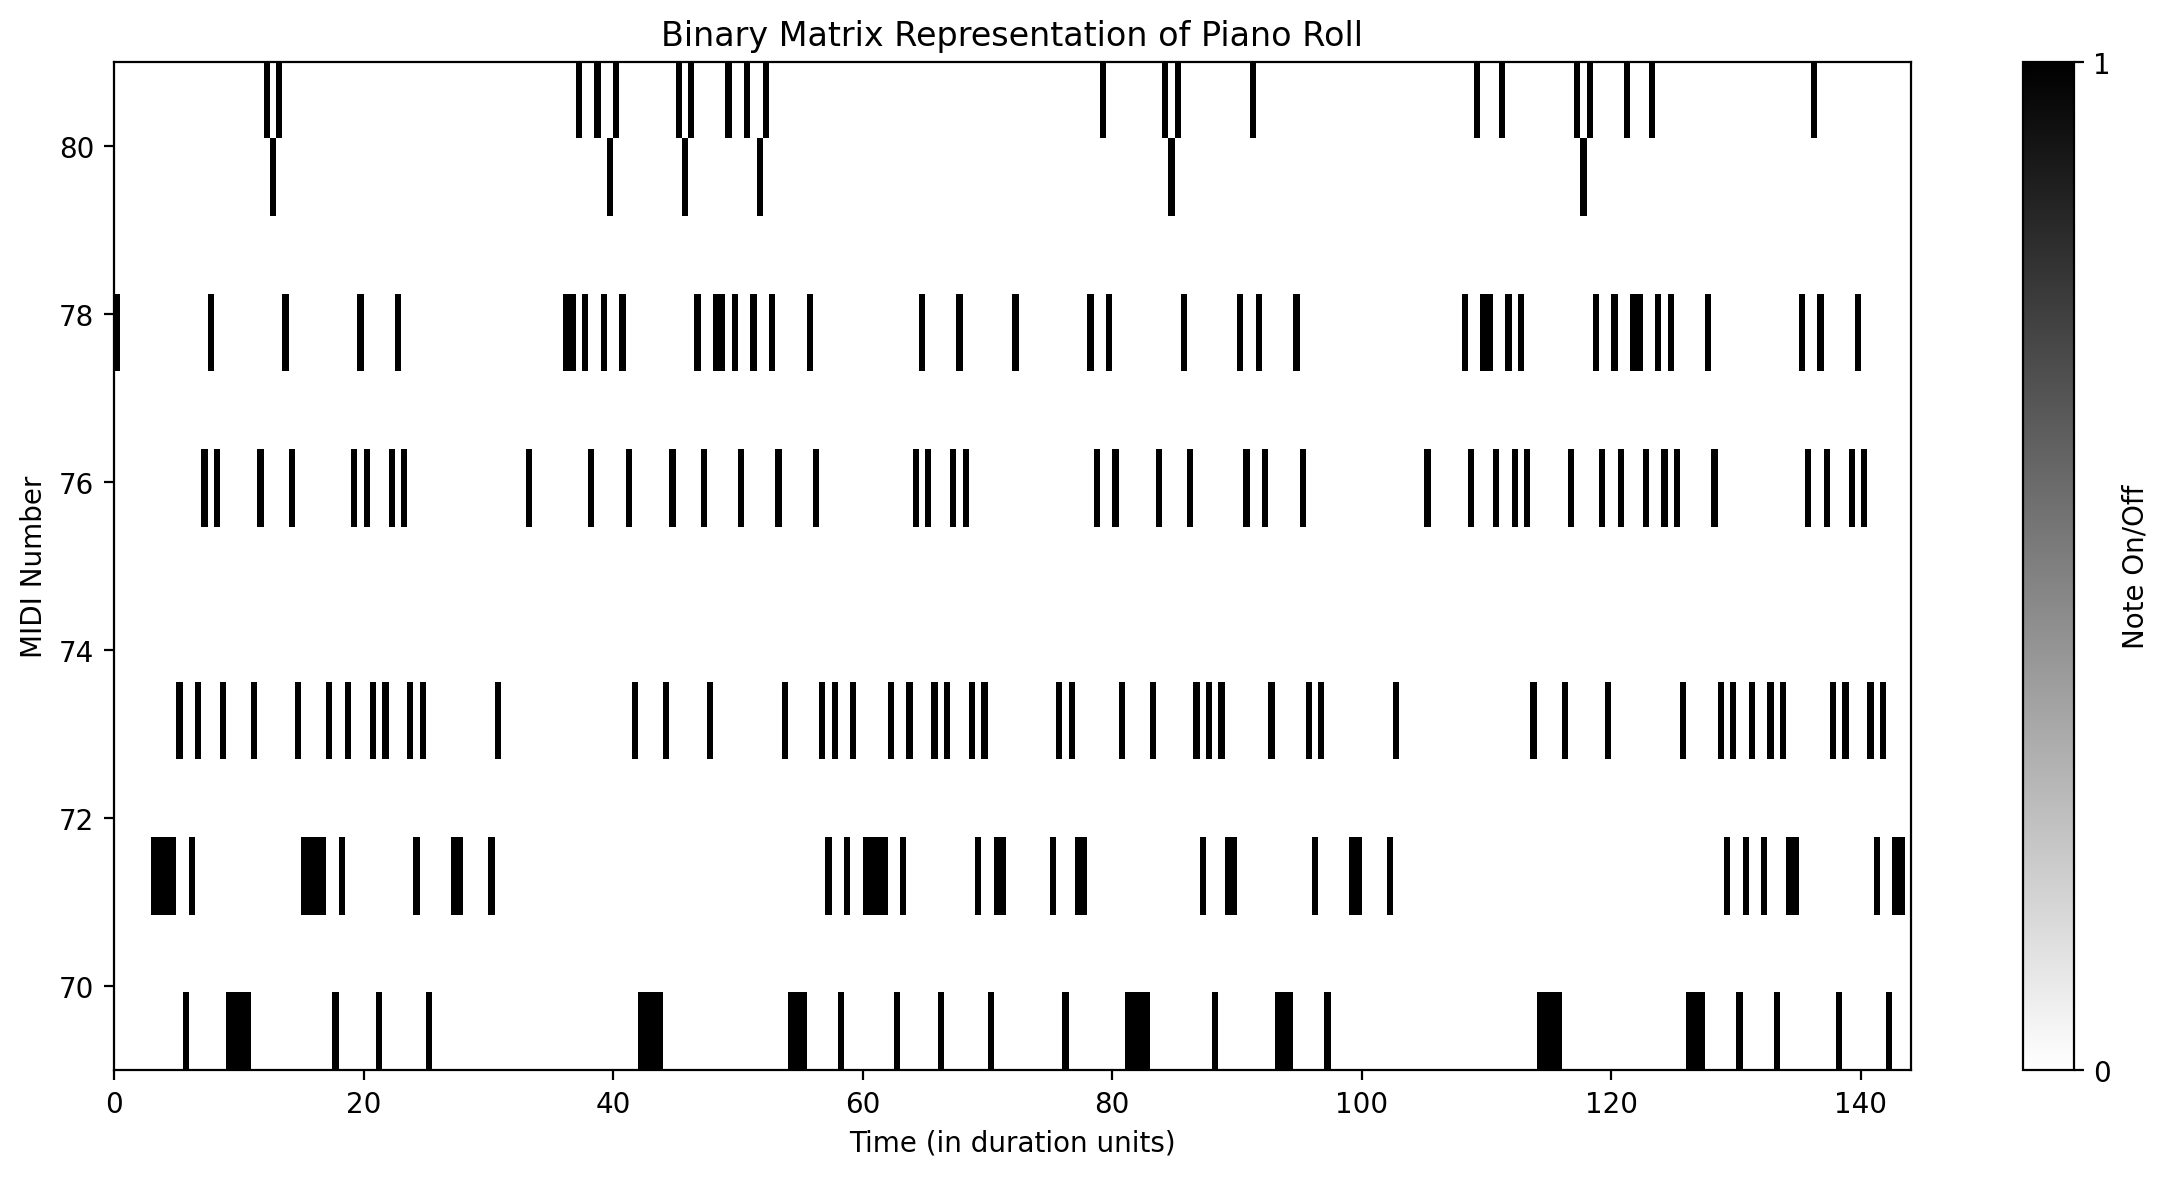

Dimensions of binary matrix: (13, 288)
Binary Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_binary_matrix(df_processed, resolution_method='auto', manual_resolution=None):
    """
    Converts a dataframe with parsed symbolic music information into a binary matrix.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing music information with at least 'MIDI',
                                    'Duration', and 'Global Onset' columns.
    - resolution_method (str): Method to determine time resolution.
                               Options: 'auto', 'manual', 'standard'
    - manual_resolution (float): The smallest duration unit to use if resolution_method is 'manual'.

    Returns:
    - binary_matrix (np.ndarray): Binary matrix representation of the piano roll.
    - lowest_midi (int): Lowest MIDI number in the data.
    - highest_midi (int): Highest MIDI number in the data.
    - num_cols (int): Number of time columns in the binary matrix.
    - resolution (float): Time resolution used.
    """
    # Step 1: Identify the range of pitches (Y-axis)
    lowest_midi = df_processed['MIDI'].min()
    highest_midi = df_processed['MIDI'].max()

    # Step 2: Determine the resolution (X-axis)
    if resolution_method == 'auto':
        resolution = df_processed['Duration'].min()
        print(f"Using automatic resolution based on smallest duration: {resolution}")
    elif resolution_method == 'manual':
        if manual_resolution is None:
            raise ValueError("manual_resolution must be provided when resolution_method is 'manual'.")
        resolution = manual_resolution
        print(f"Using manual resolution: {resolution}")
    elif resolution_method == 'standard':
        # Example of a standard musical resolution (e.g., 16th note if tempo is known)
        # Here, you might define a standard resolution based on musical context
        # For demonstration, let's assume a fixed standard resolution
        resolution = 0.25  # Example: quarter note in beats
        print(f"Using standard resolution: {resolution}")
    else:
        raise ValueError("Invalid resolution_method. Choose from 'auto', 'manual', 'standard'.")

    # Validate that resolution is positive
    if resolution <= 0:
        raise ValueError("Resolution must be a positive number.")

    # Calculate the total duration of the piece
    total_duration = df_processed['Global Onset'].max() + df_processed['Duration'].max()

    # Number of columns is total duration divided by resolution
    num_cols = int(np.ceil(total_duration / resolution))
    print(f"Total duration: {total_duration}, Number of columns: {num_cols}")

    # Step 3: Initialize a binary matrix
    binary_matrix = np.zeros((highest_midi - lowest_midi + 1, num_cols), dtype=int)

    # Step 4: Fill in the binary matrix
    for index, row in df_processed.iterrows():
        # Calculate the row corresponding to the MIDI number (flipping it)
        row_index = highest_midi - row['MIDI']

        # Calculate the columns corresponding to the Global Onset and Duration
        start_col = int(np.floor(row['Global Onset'] / resolution))
        end_col = int(np.ceil((row['Global Onset'] + row['Duration']) / resolution))

        # Handle edge cases where end_col might exceed num_cols
        end_col = min(end_col, num_cols)

        # Set the appropriate elements to 1
        binary_matrix[row_index, start_col:end_col] = 1


    # Visualization
    plt.figure(figsize=(12, 6))
    extent = [0, num_cols * resolution, lowest_midi, highest_midi]
    plt.imshow(binary_matrix, aspect='auto', origin='upper', cmap='gray_r', extent=extent)
    plt.xlabel('Time (in duration units)')
    plt.ylabel('MIDI Number')
    plt.title('Binary Matrix Representation of Piano Roll')
    plt.colorbar(label='Note On/Off', ticks=[0, 1])
    plt.tight_layout()
    plt.show()

    # Print matrix dimensions
    matrix_dimensions = binary_matrix.shape
    print(f'Dimensions of binary matrix: {matrix_dimensions}')

    # Set numpy print options to display the full array (adjust as needed)
    np.set_printoptions(threshold=1000, linewidth=100)

    # Print the binary matrix
    print('Binary Matrix:\n', binary_matrix)

    return binary_matrix, lowest_midi, highest_midi, num_cols, resolution

# Example Usage:
# Automatic resolution based on smallest duration
binary_matrix_auto, low_midi, high_midi, cols_auto, res_auto = create_binary_matrix(df_processed, resolution_method='auto')

# # Manual resolution (e.g., 0.5 time units)
# binary_matrix_manual, low_midi, high_midi, cols_manual, res_manual = create_binary_matrix(
#     df_processed,
#     resolution_method='manual',
#     manual_resolution=0.5
# )

# # Standard resolution (e.g., fixed 0.25 time units)
# binary_matrix_standard, low_midi, high_midi, cols_standard, res_standard = create_binary_matrix(
#     df_processed,
#     resolution_method='standard'
# )



In [5]:
print(binary_matrix_auto)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
import numpy as np
import mido
from mido import MidiFile, MidiTrack, Message, second2tick
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output
import pygame
import time

binary_matrix = binary_matrix_auto

def generate_midi(
    midi_matrix, 
    output_filename='output_test.mid', 
    smallest_duration_ms=400, 
    lowest_midi_pitch=51,
    tempo=500000,  # Default tempo (microseconds per beat)
    velocity=64     # Default velocity for note_on and note_off
):
    """
    Generates a MIDI file from a binary matrix.
    """
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    ticks_per_smallest_duration = second2tick(
        smallest_duration_ms / 1000, 
        mid.ticks_per_beat, 
        tempo
    )
    note_states = np.zeros(midi_matrix.shape[0], dtype=int)
    time_since_last_event = 0

    for col_index in range(midi_matrix.shape[1]):
        for row_index, note_state in enumerate(midi_matrix[:, col_index]):
            note = lowest_midi_pitch + row_index
            if note_state != note_states[row_index]:
                note_states[row_index] = note_state
                msg_type = 'note_on' if note_state == 1 else 'note_off'
                track.append(Message(
                    msg_type, 
                    note=note, 
                    velocity=velocity, 
                    time=int(time_since_last_event)
                ))
                time_since_last_event = 0
        time_since_last_event += ticks_per_smallest_duration

    for row_index, state in enumerate(note_states):
        if state == 1:
            note = lowest_midi_pitch + row_index
            track.append(Message('note_off', note=note, velocity=velocity, time=int(time_since_last_event)))

    mid.save(output_filename)
    print(f'MIDI file saved successfully: {output_filename}')

generate_midi(
    midi_matrix=binary_matrix, 
    output_filename='output_test1.mid', 
    smallest_duration_ms=150, 
    lowest_midi_pitch=51
)

pygame.init()
pygame.mixer.init()

is_playing = False
midi_file_location = "output_test1.mid"

midi_player = Output()

play_button = widgets.Button(description='Play MIDI', button_style='success')
stop_button = widgets.Button(description='Stop MIDI', button_style='danger')
stop_button.disabled = True

def play_midi(b):
    global is_playing
    with midi_player:
        clear_output(wait=True)
        try:
            pygame.mixer.music.load(midi_file_location)
            pygame.mixer.music.play()
            is_playing = True
            play_button.disabled = True
            stop_button.disabled = False
            print(f'Playing {midi_file_location}...')
        except Exception as e:
            print(f'Error playing MIDI file: {e}')

def stop_midi(b):
    global is_playing
    if is_playing:
        pygame.mixer.music.stop()
        is_playing = False
        play_button.disabled = False
        stop_button.disabled = True
        print('Playback stopped.')

play_button.on_click(play_midi)
stop_button.on_click(stop_midi)

button_box = widgets.HBox([play_button, stop_button])
display(button_box)
display(midi_player)


MIDI file saved successfully: output_test1.mid


Output()